In [ ]:

#  This NoteBook contains code to run classic ML routines against a 
#  number of familiar data sets ..
#



#  Step 00: Setup

In [ ]:

#  Largely code to control how print statements and related work
#

%load_ext autoreload
%autoreload 2

%xmode Minimal


#  Setting display options 
#
import pandas as pd
pd.set_option("display.width", 640)
   #
import numpy as np
np.set_printoptions(edgeitems = 30, linewidth = 100000, 
   formatter = dict(float = lambda x: "%.3g" % x))

#  Sets horizontal scroll for wide outputs
#
from IPython.display import display, HTML
display(HTML(""))

   ###
    
from tabulate import tabulate
#
#  How to use tabulate-
#
#  l_result = [{ "col1": 20, "col2": 30}]
#  #
#  print(tabulate(l_result, headers='keys', tablefmt='psql', showindex=False))

print("--")


In [ ]:

#  Helper functions for what we want to do below-
#
#  **  You must run this cell to do much of anything in this NoteBook

#  We use these objects to store the history of results; display only
#
class HistoryIterator:
   def __init__(self, history):
       self._history = history
       self._index = 0

   def __next__(self):
       if (self._index < len(self._history._events)):
           result = (self._history._events[self._index]["event"] , self._history._events[self._index]["measure"])
           self._index +=1
           return result
       raise StopIteration

class History:
   def __init__(self):
      self._events = list()

   def clear(self):
      self._events = list()
    
   def add(self, event, measure):
      self._events.append({"event": event, "measure": measure})

   def __iter__(self):
      return HistoryIterator(self)


l_history = History()


#  The sklearn ML routines follow a very consistent pattern. As such, we
#  put these in a function, reduce redundant code below-
#

def do_model(i_routine, i_train_data, i_train_labels, i_test_data, i_test_labels, i_name_of_test):

   #  Train whatever model
   #
   i_routine.fit(i_train_data, i_train_labels)
   
   #  Predict on the test data
   #
   l_predicted_labels = i_routine.predict(i_test_data)
   l_accuracy         = (i_routine.score(i_test_data, i_test_labels) * 100)
      #
   l_history.add(event = i_name_of_test, measure = l_accuracy)
   
   #  Output results
   #
   print(i_name_of_test + " ...")
   print("   Actual    labels from test......... %s" % (i_test_labels     ) )
   print("   Predicted labels from test......... %s" % (l_predicted_labels) )
   print(   "   ###")
   print("   Accuracy: %0.4f %%" % (l_accuracy))


print("--")


In [ ]:

#  Sometimes we want to clear history-
#

l_history.clear()

print("--")


In [ ]:

#  To add a blank line to history-
#

l_history.add(event = "", measure = "")

print("--")


#  Step A1: Iris Data load, encode

In [ ]:

#  Read the Iris data into a Pandas Dataframe
#
#     Features
#     1. sepal length in cm
#     2. sepal width in cm
#     3. petal length in cm
#     4. petal width in cm
#     5. class: 
#        Iris-setosa
#        Iris-versicolour
#        Iris-virginica
#
#  To convert class into a numeric, we use sklearn.preprocessing.LabelEncoder
#  See,
#     https://www.turing.com/kb/convert-categorical-data-in-pandas-and-scikit-learn
#

from sklearn.preprocessing import LabelEncoder

my_le = LabelEncoder()
   #
l_folder = "20_Data"
l_file   = "11_iris.data.txt"


pd_iris  = pd.read_csv((l_folder + "/" + l_file), header = 0, sep = ",",
   names = ["sl", "sw", "pl", "pw", "class"],
   dtype = {"sl": "float", "sw": "float", "pl": "float", "pw": "float", "class": "string"} )
      #
pd_iris["class_encoded"]  =  my_le.fit_transform(pd_iris["class"])
   #
pd_iris = pd_iris.drop(["class"], axis = 1)
    
    
#  Pandas.Dataframe.sample() returns a randomized set of rows, versus
#  say head(), which always returns the first n ..
#
print(tabulate(pd_iris.sample(5), headers='keys', tablefmt='psql', showindex=False))
print("Number of rows: %d" % (len(pd_iris)))

print("--")


In [ ]:

#  Split data into training and test.
#  Convert the data into numpy arrays, since the ml libraries we use later expect that.
#

import numpy as np
from sklearn.model_selection import train_test_split

np_iris = {}
   #
np_iris["train"], np_iris["test"] = train_test_split(pd_iris.to_numpy(),              #  random_state calls to shuffle the data,
   test_size = 0.20, random_state = 40)                                               #    which had arrived sorted
                                                                                      #  10% yields way too high of an accuracy
                                                                                      #    far below
print("Number of total rows: %d   Training rows: %d   Test rows: %d" %
  (len(pd_iris), len(np_iris["train"]), len(np_iris["test"])) )

print()
print("Train data:")
print("%s" % (np_iris["train"][0:5]))
print()
print("Test  data:")
print("%s" % (np_iris["test" ][0:5]))
print()
   #
print("--")


In [ ]:

#  Boxplot, and normalize ..
#
#  Normalize from,
#     https://datascience.stackexchange.com/questions/39142/normalize-matrix-in-python-numpy
#

import matplotlib.pyplot as plt 
   #
from sklearn.preprocessing import MinMaxScaler

print(type(np_iris["train"]))

plt.boxplot(np_iris["train"])
plt.show()

   ###

def my_normalize(X, x_min, x_max):
   nom = (X-X.min(axis=0))*(x_max-x_min)
   denom = X.max(axis=0) - X.min(axis=0)
   denom[denom==0] = 1
   return x_min + nom/denom 

#  If we normalize the "class" column, we lose the categorical nature
#  of that data. So, create a deep copy, then just normalize the non-
#  class columns.
#
np_iris["train_norm"] = np.copy(np_iris["train"])
np_iris["test_norm" ] = np.copy(np_iris["test" ])
   #
np_iris["train_norm"][:, :4] = my_normalize(np_iris["train_norm"][:, :4], 0, 1)
np_iris["test_norm" ][:, :4] = my_normalize(np_iris["test_norm" ][:, :4], 0, 1)

plt.boxplot(np_iris["train_norm"])
plt.show()


print("--")

#  Legend:
#
#  Per a given column-
#
#    . The lower box line, marks 1st quartile. 25% of entries are below this line
#      Middle line, 2nd.                       50% above/below
#      Top box line, 3rd.                      25% above
#
#    . The true top and bottom lines-
#      There's a formula for this; marks the boundary for entries considered outliers.
#
#           o            Outliers
#           o
#
#          ---           Q3 + 1.5 QR
#           |
#           |
#           |
#           |
#       +-------+        Q3      <-----------------+
#       |       |                                  |
#       |       |                                 1 QR
#       +-------+        Median  (Q2)              |
#       |       |                                  |
#       |       |                                  |
#       +-------+        Q1      <-----------------+
#           |
#           |
#          ---           Q1 - 1.5 QR
#
#           o
#           o
#           o            Outliers
#           o
#



#  Step A2: Iris Data train, test .. NearestCentroid

In [ ]:

from sklearn.neighbors import NearestCentroid

#  Our numpy array has 5 columns, with the last column being the class.
#  To review numpy array slicing,
#
#     To get the first 4 columns use,
#        np_iris["train"][:, :4]
#     To get the last column use,
#        np_iris["train"][:, -1]
#

do_model(NearestCentroid(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: Centroid") 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(NearestCentroid(), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: Centroid Normalized") 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")
    

#  Step A3: Iris Data train, test .. kNN

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

#  Our numpy array has 5 columns, with the last column being the class.
#  To review numpy array slicing,
#
#     To get the first 4 columns use,
#        np_iris["train"][:, :4]
#     To get the last column use,
#        np_iris["train"][:, -1]
#

do_model(KNeighborsClassifier(n_neighbors = 3), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: kNN=3" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(KNeighborsClassifier(n_neighbors = 3), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: kNN=3 Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A4: Iris Data train, test .. Naive Bayes, Gaussian

In [ ]:

from sklearn.naive_bayes import GaussianNB

#  Naive Bayes, Gaussian
#
#     Gaussian usually does better than the Multinomial below because,
#        Gaussian expects continuous values
#        Multinomial expects discreet values
#
#     And our values are continuous
#

do_model(GaussianNB(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: GaussianNB" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(GaussianNB(), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: GaussianNB Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A5: Iris Data train, test .. Naive Bayes, Multinomial

In [ ]:

from sklearn.naive_bayes import MultinomialNB

#  Naive Bayes, Multinomial
#

do_model(MultinomialNB(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: MultinomialNB" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(MultinomialNB(), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: MultinomialNB Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A6: Iris Data train, test .. Decision Tree

In [ ]:

from sklearn.tree import DecisionTreeClassifier

#  Decision Tree
#

do_model(DecisionTreeClassifier(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: DecisionTree" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(DecisionTreeClassifier(), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: DecisionTree Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A7: Iris Data train, test .. Random Forest

In [ ]:

from sklearn.ensemble import RandomForestClassifier

#  Random Forest
#

#  n_estimators, number of random trees created and trained
#

do_model(RandomForestClassifier(n_estimators = 5), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: RandomForest" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(RandomForestClassifier(n_estimators = 5), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: RandomForest Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


#  Step A8: Iris Data train, test .. Support Vector Machine (SVM)

In [ ]:

from sklearn.svm import SVC

#  Support Vector Machine
#
#  We run this one with a number of configurations ..
#
#     C      ==  margin constant
#     gamma  ==  used by the Gaussian kernel
#

do_model(SVC(kernel = "linear", C = 1.0), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: SVC/Linear" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()
             
#  do_model(SVC(kernel = "linear", C = 1.0), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: SVC/Linear Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
#  print()

             
do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.25), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: RBF" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()
             
#  do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.25), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: RBF Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
#  print()

             
do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: RBF 2" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()

#  do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: RBF 2 Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
#  print()

print("--")


In [ ]:

####################################################################
####################################################################
####################################################################


##  Block: All things Breast Cancer

#  Step B1:  Breast Cancer Data load, encode, normalize

In [ ]:

#  Read the Breast Cancer data into a Pandas Dataframe
#
#     Features
#     1)     ID number
#     2)     Diagnosis (M = malignant, B = benign)
#     3-32)
#       Ten real-valued features are computed for each cell nucleus:
#     
#     	a) radius (mean of distances from center to points on the perimeter)
#     	b) texture (standard deviation of gray-scale values)
#     	c) perimeter
#     	d) area
#     	e) smoothness (local variation in radius lengths)
#     	f) compactness (perimeter^2 / area - 1.0)
#     	g) concavity (severity of concave portions of the contour)
#     	h) concave points (number of concave portions of the contour)
#     	i) symmetry 
#     	j) fractal dimension ("coastline approximation" - 1)
#
#  Sample data line,
#     842302,M,
#     17.99,    10.38,    122.8,    1001,    0.1184,    0.2776,    0.3001,    0.1471,    0.2419,    0.07871,         #  10 count
#     1.095,    0.9053,   8.589,    153.4,   0.006399,  0.04904,   0.05373,   0.01587,   0.03003,   0.006193,
#     25.38,    17.33,    184.6,    2019,    0.1622,    0.6656,    0.7119,    0.2654,    0.4601     ,0.1189
#

from sklearn.preprocessing import LabelEncoder

my_le = LabelEncoder()
   #
l_folder = "20_Data"
l_file   = "22_wdbc.data.txt"


pd_bc  = pd.read_csv((l_folder + "/" + l_file), header = 0, sep = ",",
   names = ["id", "class",
            "f01", "f02", "f03", "f04", "f05", "f06", "f07", "f08", "f09", "f10", 
            "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19", "f20", 
            "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29", "f30", 
           ],
   dtype = {"id": "int", "class": "string",
            "f01": "float", "f02": "float", "f03": "float", "f04": "float", "f05": "float", "f06": "float", "f07": "float", "f08": "float", "f09": "float", "f10": "float", 
            "f11": "float", "f12": "float", "f13": "float", "f14": "float", "f15": "float", "f16": "float", "f17": "float", "f18": "float", "f19": "float", "f20": "float", 
            "f21": "float", "f22": "float", "f23": "float", "f24": "float", "f25": "float", "f26": "float", "f27": "float", "f28": "float", "f29": "float", "f30": "float", 
           } )
      #
pd_bc["class_encoded"]  =  my_le.fit_transform(pd_bc["class"])
   #
pd_bc = pd_bc.drop(["class", "id"], axis = 1)
    
    
#  Pandas.Dataframe.sample() returns a randomized count of rows
#
print(tabulate(pd_bc.sample(5), headers='keys', tablefmt='psql', showindex=False))
print("Number of rows: %d" % (len(pd_bc)))

print("--")


In [ ]:

#  Split data into training and test.
#  Convert the data into numpy arrays, since the ml libraries we use later expect that.
#

import numpy as np
from sklearn.model_selection import train_test_split

np_bc = {}
   #
np_bc["train"], np_bc["test"] = train_test_split(pd_bc.to_numpy(),                    #  random_state calls to shuffle the data,
   test_size = 0.20, random_state = 40)                                               #    which had arrived sorted
                                                                                      #  10% yields way too high of an accuracy
                                                                                      #    far below
print("Number of total rows: %d   Training rows: %d   Test rows: %d" %
  (len(pd_bc), len(np_bc["train"]), len(np_bc["test"])) )

print()
print("Train data:")
print("%s" % (np_bc["train"][0:5]))
print()
print("Test  data:")
print("%s" % (np_bc["test" ][0:5]))
print()
   #
print("--")


In [ ]:

#  Normalizing the data
#

def my_normalize(X, x_min, x_max):
   nom = (X-X.min(axis=0))*(x_max-x_min)
   denom = X.max(axis=0) - X.min(axis=0)
   denom[denom==0] = 1
   return x_min + nom/denom 


print("Number of columns in matrix: %d" % (np_bc["train"].shape[1]))
      
#  If we normalize the "class" column, we lose the categorical nature
#  of that data. So, create a deep copy, then just normalize the non-
#  class columns.
#
np_bc["train_norm"] = np.copy(np_bc["train"])
np_bc["test_norm" ] = np.copy(np_bc["test" ])
   #
np_bc["train_norm"][:, :30] = my_normalize(np_bc["train_norm"][:, :30], 0, 1)
np_bc["test_norm" ][:, :30] = my_normalize(np_bc["test_norm" ][:, :30], 0, 1)

plt.boxplot(np_bc["train"     ])
plt.show()
plt.boxplot(np_bc["train_norm"])
plt.show()


print("--")


#  Step B2:  Breast Cancer Data, run against all models ..

In [ ]:

#  All of our model libraries were imported above, but ..
#
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


#  To add a blank line to history-
#
l_history.add(event = "", measure = "")


#  Our numpy array has many columns, with the last column being the class.
#
#  To review numpy array slicing,
#
#     To get the first 30 columns use,
#        np_iris["train"][:, :30]
#     To get the last column use,
#        np_iris["train"][:, -1]
#

do_model(NearestCentroid(), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: Centroid") 
#  do_model(NearestCentroid(), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: Centroid Normalized") 
print()

do_model(KNeighborsClassifier(n_neighbors = 3), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: kNN=3") 
#  do_model(KNeighborsClassifier(n_neighbors = 3), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: kNN=3 Normalized") 
print()

do_model(GaussianNB(), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: GaussianNB") 
#  do_model(GaussianNB(), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: GaussianNB Normalized") 
print()

do_model(MultinomialNB(), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: MultinomialNB") 
#  do_model(MultinomialNB(), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: MultinomialNB Normalized") 
print()

do_model(DecisionTreeClassifier(), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: DecisionTree") 
#  do_model(DecisionTreeClassifier(), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: DecisionTree Normalized") 
print()

#  n_estimators, number of random trees created and trained
#
do_model(RandomForestClassifier(n_estimators = 5), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: Random Forest = 5") 
#  do_model(RandomForestClassifier(n_estimators = 5), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: Random Forest = 5 Normalized") 
print()

   ###

#  Support Vector Machine
#
#  We run this one with a number of configurations ..
#
#     C      ==  margin constant
#     gamma  ==  used by the Gaussian kernel
#

do_model(SVC(kernel = "linear", C = 1.0), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: SVC/Linear") 
#  do_model(SVC(kernel = "linear", C = 1.0), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: SVC/Linear Normalized") 
print()

do_model(SVC(kernel = "rbf", C = 1.0, gamma = 1.0), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: RBF") 
#  do_model(SVC(kernel = "rbf", C = 1.0, gamma = 1.0), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: RBF Normalized") 
print()

do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: RBF 2") 
#  do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: RBF 2 Normalized") 
print()


print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()

print("--")


In [ ]:

####################################################################
####################################################################
####################################################################


#  Step C1:  MNist Data load, encode, other

In [ ]:

#  We will be using Keras, so pip install it inside the Jupyter NoteBook container ..
#

l_package1 = "keras"
l_package2 = "tensorflow"
    
def my_func(arg1):
    
   import sys
   import subprocess
    
   subprocess.check_call([sys.executable, "-m", "pip", "install", arg1 ])
      #
   print("From each host ..")
      #
   return


   ##########################################
    

print("Install Python Pip packages on Jupyter container ..")
   #
my_return = my_func(l_package1)
my_return = my_func(l_package2)
print()
    

#  Use this if installing o nthe KGIP worker nodes ..
#
#  print("Install Python Pip packages on KGIP worker node containers ..")
#     # 
#  my_return = my_graph.run(lambda g: my_func(l_package))
#  print()
    
print("--")



In [ ]:

#  Intead of loading MNist from disk, we load it from the Keras library ..
#

import keras
from keras.datasets import mnist


np_mnist = {}
   #
(np_mnist["train"], np_mnist["train_label"]), (np_mnist["test"], np_mnist["test_label"]) = mnist.load_data()


#  train and test ccome in as an array [(n), 28, 28] where n == 60000 for train,
#  and 100000 for test
#
#  We need that 28*28 as a vector, so ..
#
np_mnist["train_v"] = np_mnist["train"].reshape(-1, 28*28)
np_mnist["test_v"]  = np_mnist["test" ].reshape(-1, 28*28)


print("Train shape ................ %s" % (str(np_mnist["train"].shape)))
print("Train label shape .......... %s" % (str(np_mnist["train_label"].shape)))
   #
print("Test  shape ................ %s" % (str(np_mnist["test"].shape)))
print("Test  label shape .......... %s" % (str(np_mnist["test_label"].shape)))
   #
print("Train vector shape ......... %s" % (str(np_mnist["train_v"].shape)))
print("Test  vector shape ......... %s" % (str(np_mnist["test_v" ].shape)))
   #
print()


#  tabulate() displays poorly with this wide data. Straight up print() works well.
#
# print(tabulate(np_mnist["train"][0:2], headers='keys', tablefmt='psql', showindex=False))
print(np_mnist["train"][0:2])
print("Number of rows: %d" % (len(np_mnist["train"])))
   #
print()

print(np_mnist["train_label"][0:2])
print("Number of rows: %d" % (len(np_mnist["train_label"])))
   #
print()


print(np_mnist["test"][0:2])
print("Number of rows: %d" % (len(np_mnist["test"])))
   #
print()

print(np_mnist["test_label"][0:2])
print("Number of rows: %d" % (len(np_mnist["test_label"])))
   #
print()

    
print("--")


#  Step CN: Results

In [ ]:

#  Sample results
#
#     Train shape ................ (60000, 28, 28)
#     Train label shape .......... (60000,)
#     Test  shape ................ (10000, 28, 28)
#     Test  label shape .......... (10000,)
#     Train vector shape ......... (60000, 784)
#     Test  vector shape ......... (10000, 784)
#     
#     [[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
#       [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
#       [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
#       [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0  80 156 107 253 253 205  11   0  43 154   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0  14   1 154 253  90   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0 139 253 190   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0  11 190 253  70   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0  35 241 225 160 108   1   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0  81 240 253 253 119  25   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  45 186 253 253 150  27   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  16  93 252 253 187   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 249 253 249  64   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  46 130 183 253 253 207   2   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0  39 148 229 253 253 253 250 182   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0  24 114 221 253 253 253 253 201  78   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0  23  66 213 253 253 253 253 198  81   2   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0  18 171 219 253 253 253 253 195  80   9   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0  55 172 226 253 253 253 253 244 133  11   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0 136 253 253 253 212 135 132  16   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
#     
#      [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253 159  50   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252 253 122   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 253 252 252  96 189 253 167   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0  51 238 253 253 190 114 253 228  47  79 255 168   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0  48 238 252 252 179  12  75 121  21   0   0 253 243  50   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0  38 165 253 233 208  84   0   0   0   0   0   0 253 252 165   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   7 178 252 240  71  19  28   0   0   0   0   0   0 253 252 195   0   0   0   0   0]
#       [  0   0   0   0   0   0   0  57 252 252  63   0   0   0   0   0   0   0   0   0 253 252 195   0   0   0   0   0]
#       [  0   0   0   0   0   0   0 198 253 190   0   0   0   0   0   0   0   0   0   0 255 253 196   0   0   0   0   0]
#       [  0   0   0   0   0   0  76 246 252 112   0   0   0   0   0   0   0   0   0   0 253 252 148   0   0   0   0   0]
#       [  0   0   0   0   0   0  85 252 230  25   0   0   0   0   0   0   0   0   7 135 253 186  12   0   0   0   0   0]
#       [  0   0   0   0   0   0  85 252 223   0   0   0   0   0   0   0   0   7 131 252 225  71   0   0   0   0   0   0]
#       [  0   0   0   0   0   0  85 252 145   0   0   0   0   0   0   0  48 165 252 173   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0  86 253 225   0   0   0   0   0   0 114 238 253 162   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0  85 252 249 146  48  29  85 178 225 253 223 167  56   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0  85 252 252 252 229 215 252 252 252 196 130   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0  28 199 252 252 253 252 252 233 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0  25 128 252 253 252 141  37   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]]
#     Number of rows: 60000
#     
#     [5 0]
#     Number of rows: 60000
#     
#     [[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 198 198 198 198 198 198 170  52   0   0   0   0   0   0]
#       [  0   0   0   0   0   0  67 114  72 114 163 227 254 225 254 254 254 250 229 254 254 140   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0  17  66  14  67  67  67  59  21 236 254 106   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  83 253 209  18   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  22 233 255  83   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 129 254 238  44   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  59 249 254  62   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 133 254 187   5   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   9 205 248  58   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 126 254 182   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  75 251 240  57   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0  19 221 254 166   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   3 203 254 219  35   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0  38 254 254  77   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0  31 224 254 115   1   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0 133 254 254  52   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0  61 242 254 254  52   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0 121 254 254 219  40   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0 121 254 207  18   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
#     
#      [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0 116 125 171 255 255 150  93   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0 169 253 253 253 253 253 253 218  30   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0 169 253 253 253 213 142 176 253 253 122   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0  52 250 253 210  32  12   0   6 206 253 140   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0  77 251 210  25   0   0   0 122 248 253  65   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0  31  18   0   0   0   0 209 253 253  65   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0 117 247 253 198  10   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0  76 247 253 231  63   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0 128 253 253 144   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0 176 246 253 159  12   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0  25 234 253 233  35   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0 198 253 253 141   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0  78 248 253 189  12   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0  19 200 253 253 141   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0 134 253 253 173  12   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0 248 253 253  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0 248 253 253  43  20  20  20  20   5   0   5  20  20  37 150 150 150 147  10   0]
#       [  0   0   0   0   0   0   0   0 248 253 253 253 253 253 253 253 168 143 166 253 253 253 253 253 253 253 123   0]
#       [  0   0   0   0   0   0   0   0 174 253 253 253 253 253 253 253 253 253 253 253 249 247 247 169 117 117  57   0]
#       [  0   0   0   0   0   0   0   0   0 118 123 123 123 166 253 253 253 155 123 123  41   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
#       [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]]
#     Number of rows: 10000
#     
#     [7 2]
#     Number of rows: 10000


#  Step CN: End of results

#  Step C2: MNist train, test .. (All)

In [ ]:

#  Sometimes we want to clear history-
#

l_history.clear()

print("--")


In [ ]:

#  All of our model libraries were imported above, but ..
#

#  Here we run given ML routines against the MNist data set
#
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#  Adding these to the above
#
from sklearn.svm import LinearSVC
from sklearn import decomposition

import time

print("--")


In [ ]:

#  To add a blank line to history-
#
l_history.add(event = "", measure = "")


do_model(NearestCentroid(), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: Centroid") 
print()

do_model(KNeighborsClassifier(n_neighbors =  3), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: kNN=3" ) 
do_model(KNeighborsClassifier(n_neighbors =  7), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: kNN=7") 
print()

do_model(GaussianNB(), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: GaussianNB") 
print()

do_model(MultinomialNB(), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: MultinomialNB") 
print()

do_model(DecisionTreeClassifier(), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: DecisionTree") 
print()

#  n_estimators, number of random trees created and trained
#
do_model(RandomForestClassifier(n_estimators = 5   ), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: Random Forest = 5   ") 
do_model(RandomForestClassifier(n_estimators = 50  ), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: Random Forest = 50  ") 
do_model(RandomForestClassifier(n_estimators = 500 ), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: Random Forest = 500 ") 
do_model(RandomForestClassifier(n_estimators = 5000), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: Random Forest = 5000") 

print()

   ###

#  Support Vector Machine
#
#  We run this one with a number of configurations ..
#
#     C      ==  margin constant
#     gamma  ==  used by the Gaussian kernel
#

#  As configured, these throw warnings, never settle ..
#

#  do_model(LinearSVC(C = 0.01), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: LinearSVC c=0.01   ") 
#  print()
#  do_model(LinearSVC(C = 0.1 ), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: LinearSVC c=0.1    ") 
#  print()
#  do_model(LinearSVC(C = 1.0 ), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: LinearSVC c=1.0    ") 
#  print()
#  do_model(LinearSVC(C = 10.0), np_mnist["train_v"], np_mnist["train_label"], np_mnist["test_v"], np_mnist["test_label"], "MNist: LinearSVC c=10.0   ") 
#  print()

print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()

print("--")


#  Step CN: Results

In [ ]:

#  Sample results
#
#     MNist: Centroid ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 2 9 0 2 9 0 1 5 9 7 3 4 7 6 4 5 4 0 7 4 0 1 ... 3 2 4 9 4 2 6 4 1 7 0 6 6 0 1 8 8 4 5 6 7 8 4 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 82.0300 %
#     
#     MNist: kNN=3 ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 3 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 97.0500 %
#     MNist: kNN=7 ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 6 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 96.9400 %
#     
#     MNist: GaussianNB ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [9 2 1 0 9 1 8 9 4 9 0 6 9 0 1 0 9 7 2 9 9 6 6 8 9 0 7 9 0 1 ... 6 0 8 9 8 8 6 9 1 9 3 6 6 0 1 9 8 9 8 6 9 8 9 0 1 8 8 9 8 6]
#        ###
#        Accuracy: 55.5800 %
#     
#     MNist: MultinomialNB ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 4 9 0 6 9 0 1 3 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 2 2 4 9 4 2 6 4 1 7 2 6 6 0 1 8 8 4 5 6 7 8 9 0 1 2 3 9 8 6]
#        ###
#        Accuracy: 83.6500 %
#     
#     MNist: DecisionTree ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 7 6 9 0 6 9 0 1 5 9 7 6 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 8 4 1 7 5 6 8 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 87.6700 %
#     
#     MNist: Random Forest = 5    ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 4 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 2 6 4 1 7 8 6 6 0 1 2 3 4 5 6 7 3 9 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 91.9100 %
#     MNist: Random Forest = 50   ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 2 6 4 1 7 3 6 3 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 96.7000 %
#     MNist: Random Forest = 500  ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 2 6 4 1 7 2 6 6 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 97.0400 %
#     MNist: Random Forest = 5000 ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 3 2 4 9 4 2 6 4 1 7 2 6 6 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 97.1800 %
#     
#     /opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
#       warnings.warn(
#     
#     MNist: LinearSVC c=0.01    ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 2 4 9 6 6 5 4 0 7 4 0 1 ... 3 2 4 9 4 3 6 4 1 7 3 6 6 0 1 2 3 4 5 6 7 3 9 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 87.1200 %
#     
#     /opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
#       warnings.warn(
#     
#     MNist: LinearSVC c=0.1     ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 1 6 4 0 6 9 0 1 5 9 7 2 4 9 6 6 5 4 0 7 4 0 1 ... 3 2 4 4 4 2 6 4 1 7 3 6 6 0 1 2 3 4 5 6 7 3 4 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 86.4700 %
#     
#     /opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
#       warnings.warn(
#     
#     MNist: LinearSVC c=1.0     ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 4 9 4 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 3 2 4 9 4 3 6 4 1 7 3 6 2 0 1 2 3 4 5 6 7 3 9 0 1 2 3 4 5 6]
#        ###
#        Accuracy: 83.9900 %
#     
#     MNist: LinearSVC c=10.0    ...
#        Actual    labels from test......... [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 5 2 4 9 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
#        Predicted labels from test......... [7 2 1 0 4 1 8 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 ... 3 2 4 9 4 3 6 4 1 7 3 6 6 0 1 8 8 4 5 6 7 8 9 0 1 8 3 5 5 6]
#        ###
#        Accuracy: 83.6900 %
#     
#     
#     +-----------------------------+------------+
#     | Category                    | Accuracy   |
#     |-----------------------------+------------|
#     |                             |            |
#     | MNist: Centroid             | 82.03      |
#     | MNist: kNN=3                | 97.05      |
#     | MNist: kNN=7                | 96.94      |
#     | MNist: GaussianNB           | 55.58      |
#     | MNist: MultinomialNB        | 83.65      |
#     | MNist: DecisionTree         | 87.67      |
#     | MNist: Random Forest = 5    | 91.91      |
#     | MNist: Random Forest = 50   | 96.7       |
#     | MNist: Random Forest = 500  | 97.04      |
#     | MNist: Random Forest = 5000 | 97.18      |
#     | MNist: LinearSVC c=0.01     | 87.12      |
#     | MNist: LinearSVC c=0.1      | 86.47      |
#     | MNist: LinearSVC c=1.0      | 83.99      |
#     | MNist: LinearSVC c=10.0     | 83.69      |
#     +-----------------------------+------------+
#     
#     --
#     
#     /opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
#       warnings.warn(


In [ ]:

#  Regarding this,
#
#     /opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:
#        Liblinear failed to converge, increase the number of iterations.
#        warnings.warn(
#
#  From,
#     https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati
#
#      Normally when an optimization algorithm does not converge, it is usually because the problem is not well-conditioned,
#      perhaps due to a poor scaling of the decision variables. There are a few things you can try.
#      
#          Normalize your training data so that the problem hopefully becomes more well conditioned, which in turn can speed up
#          convergence. One possibility is to scale your data to 0 mean, unit standard deviation using Scikit-Learn's StandardScaler
#          for an example.
#
#          Note that you have to apply the StandardScaler fitted on the training data to the test data. Also, if you have discrete
#          features, make sure they are transformed properly so that scaling them makes sense.
#
#          Related to 1), make sure the other arguments such as regularization weight, C, is set appropriately. C has to be > 0.
#          Typically one would try various values of C in a logarithmic scale (1e-5, 1e-4, 1e-3, ..., 1, 10, 100, ...) before
#          finetuning it at finer granularity within a particular interval. These days, it probably make more sense to tune
#          parameters using, for e.g., Bayesian Optimization using a package such as Scikit-Optimize.
#
#          Set max_iter to a larger value. The default is 1000. This should be your last resort. If the optimization process does
#          not converge within the first 1000 iterations, having it converge by setting a larger max_iter typically masks other
#          problems such as those described in 1) and 2). It might even indicate that you have some in appropriate features or
#          strong correlations in the features. Debug those first before taking this easy way out.
#
#          Set dual = True if number of features > number of examples and vice versa. This solves the SVM optimization problem using
#          the dual formulation. Thanks @Nino van Hooff for pointing this out, and @JamesKo for spotting my mistake.
#
#          Use a different solver, for e.g., the L-BFGS solver if you are using Logistic Regression. See @5ervant's answer.
#      
#      Note: One should not ignore this warning.
#      
#      This warning came about because
#      
#          Solving the linear SVM is just solving a quadratic optimization problem. The solver is typically an iterative algorithm
#          that keeps a running estimate of the solution (i.e., the weight and bias for the SVM). It stops running when the solution
#          corresponds to an objective value that is optimal for this convex optimization problem, or when it hits the maximum number
#          of iterations set.
#      
#          If the algorithm does not converge, then the current estimate of the SVM's parameters are not guaranteed to be any good, 
#          hence the predictions can also be complete garbage.



#  Step CN: End of results

#  Step C3: Compare MNist test when data is randomized ..

In [ ]:


#  Effect of randomness, moving the bits around inside each image
#

#  The following variables are in scope ..
#
#     np_mnist["train"] 
#     np_mnist["train_label"]
#     np_mnist["test"]
#     np_mnist["test_label"]
#     np_mnist["train_v"]           #  vectors of the two data sets above
#     np_mnist["test_v"] 
#

#  Here we want to copy the two "v" arrays and randomize them
#
np_mnist["train_v_s"] = np.copy(np_mnist["train_v"])
np_mnist["test_v_s" ] = np.copy(np_mnist["test_v" ])
   #
for i in range(np_mnist["train_v_s"].shape[0]):
   np.random.shuffle(np_mnist["train_v_s"][i, :])
for i in range(np_mnist["test_v_s" ].shape[0]):
   np.random.shuffle(np_mnist["test_v_s" ][i, :])


#  Looking at the non-scrambled, and yes-scrambled data
#
#  Currently the data lives as a vector. To look at it, copy
#  it back to a 28*28 numpy array. We only need this for two
#  rows we wish to view, and we choose to use test.
#
np_mnist["test_s"] = np.zeros((2, np_mnist["test"].shape[1], np_mnist["test"].shape[2]), dtype = int)
   #
for i in range(np_mnist["test_s"].shape[0]):
   np_mnist["test_s"][i,:,:] = np_mnist["test_v_s"][i].reshape(28, 28)

#  And the actual print
#
#  Non-randomized bits
#
print(np_mnist["test_label"][0:2])
print(np_mnist["test"][0:2])
print("Number of rows: %d" % (len(np_mnist["test"])))
   #
print()

#  Problems with print formatting. These lines help
#
np.set_printoptions()
np.set_printoptions(edgeitems = 30, linewidth = 100000,  formatter = dict(int = lambda x: "%3i" % x))

#  Randomized bits
#
print(np_mnist["test_label"][0:2])
print(np_mnist["test_s"][0:2])
print("Number of rows: %d" % (len(np_mnist["test_s"])))
   #
print()







print("--")



NameError: name 'Text' is not defined

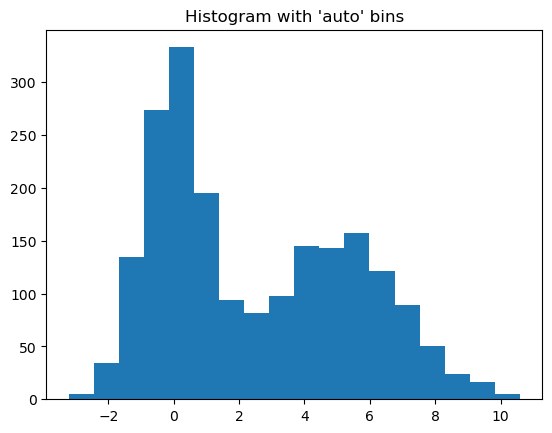

In [19]:


import matplotlib.pyplot as plt

rng = np.random.RandomState(10)                                # deterministic random data

a = np.hstack((rng.normal(size=1000), rng.normal(loc=5, scale=2, size=1000)))

_ = plt.hist(a, bins='auto')                                   # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")
Text(0.5, 1.0, "Histogram with 'auto' bins")

plt.show()


#  Step CN: Results

In [ ]:

#  Sample results
#




#  Step CN: End of results

In [ ]:

#  The results below were on images that were not scrambled.
#
#     +-----------------------------+-------------------+
#     | Category                    | Accuracy          |
#     |-----------------------------+-------------------|
#     | MNist: Centroid             | 82.03             |
#     | MNist: kNN=3                | 97.05             |
#     | MNist: kNN=7                | 96.94             |
#     | MNist: GaussianNB           | 55.58             |
#     | MNist: MultinomialNB        | 83.65             |
#     | MNist: DecisionTree         | 87.72             |
#     | MNist: Random Forest = 5    | 92.36999999999999 |
#     | MNist: Random Forest = 50   | 96.67999999999999 |
#     | MNist: Random Forest = 500  | 97.15             |
#     | MNist: Random Forest = 5000 | 97.17             |
#     |                             |                   |
#     +-----------------------------+-------------------+

#  Rerun now o nthe scrambled images
#

#  To add a blank line to history-
#
l_history.add(event = "", measure = "")


do_model(NearestCentroid(), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: Centroid, Scramble") 
print()

#  do_model(KNeighborsClassifier(n_neighbors =  3), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: kNN=3, Scramble" ) 
#  do_model(KNeighborsClassifier(n_neighbors =  7), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: kNN=7, Scramble") 
#  print()

#  do_model(GaussianNB(), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: GaussianNB, Scramble") 
#  print()

#  do_model(MultinomialNB(), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: MultinomialNB, Scramble") 
#  print()

#  do_model(DecisionTreeClassifier(), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: DecisionTree, Scramble") 
#  print()

#  n_estimators, number of random trees created and trained
#
#  do_model(RandomForestClassifier(n_estimators = 5   ), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: Random Forest = 5   , Scramble") 
#  do_model(RandomForestClassifier(n_estimators = 50  ), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: Random Forest = 50  , Scramble") 
#  do_model(RandomForestClassifier(n_estimators = 500 ), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: Random Forest = 500 , Scramble") 
#  do_model(RandomForestClassifier(n_estimators = 5000), np_mnist["train_scramble_v"], np_mnist["train_label"], np_mnist["test_scramble_v"], np_mnist["test_label"], "MNist: Random Forest = 5000, Scramble") 

print()

   ###

print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()

print("--")



#  Step CN: Results

#  Step CN: End of results